# Seq2Seq z atencją - analiza modelu

Cześć! 
Ten notebook stworzony jest do eksploracji i praktycznego wykorzystania możliwości modelu *seq2seq z mechanizmem atencji*!. Dzięki przerobieniu wszystkich proponowanych przez nas zadań, dowiesz się jak: 
- wczytać przetrenowany model 
- wygenerować predykcje z modelu seq2seq
- wyciągnąć z modelu reprezentację dokumentów i porównać je ze sobą
- wyciągnąć z modelu wagi atencji i odnaleźć dla każdego ogłoszenia najważniejsze słowa
- sprawdzić które słowa są najbardziej znaczące dla każdej z naszych kategorii

Pracujemy na zbiorze z treściami ofert pracy. Oprócz treści oferty pracy, udostępniona jest również nazwa danego stanowiska (nie będziemy jej jednak wykorzystywać podczas tych ćwiczeń). Model został wytrenowany na zbiorze treningowym (17000 wpisów) i zwalidowany (3000 wpisów). Zbiór testowy, na którym będziemy pracować zawiera 1000 wpisów. <br>
W każdym ze wspomnianych zbiorów znajduje się 35 kategorii, które mogą przyjąć oferty. Niektóre z nich są do siebie dość podobne (np. "IT - Rozwój oprogramowania" i "IT - Administracja", a niektóre dość różne np. "Marketing" i "Inżynieria"). Skrypty użyte do przetwarzania danych i wytrenowania ich dostępne są w pliku `Modul2 [seq2seqAttn] Przetwarzanie danych i trenowanie modelu`.
<br>

Najpierw zaimportujmy potrzebne biblioteki i zdefiniujmy istotne zmienne i funkcje.

In [1]:
import pandas as pd
import pickle
import numpy as np
from keras.models import load_model, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Input, Concatenate
from keras.initializers import Constant
from layers.attention import AttentionDecoder 
from utils.text_helpers import *
from utils.analysis_helpers import *
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
dataset_details = {
    'data_focus': 'job_content',
    'max_number_words': 20000,
    'max_seq_len': 250
}

In [3]:
#wczytanie danych

#data_focus - na której kolumnie się skupiamy; job_content - treść oferty; job_name - nazwa stanowiska
#max_number_words - jaka jest wielkość naszego słownika?
#max_seq_len - ile maksymalnie tokenów z każdej oferty pracy rozważamy? 


data = Data(dataset_details['data_focus'])
data.preprocess_data(max_number_words=dataset_details['max_number_words'], max_seq_len=dataset_details['max_seq_len'])


#definicja argumentów sieci
#embedding_dim - wymiarowość każdego embeddingu
#embeddings - klucz zawierający macierz embeddingów dla naszego słownika
#train_embeddings - czy trenować embeddingi
#latent_dim - wymiar ukrytych stanów w LSTM/AttentionDecoder
#return_probabilities - klucz określający czy jesteśmy zainteresowani predykcjami (False) czy wagami atencji (True)
#num_decoder_tokens - liczba kategorii + 2 (dekodujemy kategorię + znak, że predykcja jest zakończona)

def load_embeddings(file):
    with open(file, 'rb') as f: 
        x = pickle.load(f)
    return x


args = {
    'embedding_dim': 300,
    'embeddings': load_embeddings('data/embedding_matrix.pickle'),
    'train_embeddings': True,
    'latent_dim': dataset_details['max_seq_len'],
    'dropout': 0.5, 
    'num_decoder_tokens': 37,
    'batch_size': 500, 
    'num_epochs': 5,
    'return_probabilities': False,
}

network = Network(args)

In [4]:
#dzięki tej komendzie łatwo zobaczymy jakie własności zawiera nasz obiekt
print(data.__dict__.keys())

dict_keys(['data_focus', 'training_set', 'test_set', 'raw_train_X', 'raw_val_X', 'raw_train_y', 'raw_val_y', 'raw_test_X', 'raw_test_y', 'tokenizer', 'cleaner', 'unique_class_names', 'train_X', 'val_X', 'test_X', 'train_y', 'train_y_input', 'train_y_output', 'val_y', 'val_y_input', 'val_y_output', 'test_y', 'test_y_input', 'test_y_output'])


***Zadanie 1***. Na podstawie części teoretycznej i notebooka `Modul2 [seq2seqAttn] Przetwarzanie danych i trenowanie modelu`, wypełnij strukturę sieci, która odpowiada za encoder. W ramach wykonania zadania, do sieci powinny być dodane dwa bloki - jeden odpowiadający za embeddingi inputu, a drugi za dwukierunkowy LSTM jako encoder.

In [5]:
def seq2seq(network):
    encoder_inputs = Input(shape=(None,), name='encoder_input')
    #dodaj warstwę embeddingów i encodera, a następnie wczytaj model z pliku
    embedding_layer = Embedding(input_dim=len(network.embeddings),
                                output_dim=network.embedding_dim,
                                embeddings_initializer = Constant(network.embeddings),
                                trainable=network.train_embeddings, name='embeddings')  
    embedded_sequences = embedding_layer(encoder_inputs)
    encoder = Bidirectional(LSTM(network.latent_dim, return_sequences=True, dropout=network.dropout), name='encoder')
    states =  encoder(embedded_sequences)
    outputs_true = Input(shape=(None, None,), dtype='int64', name='decoder_input')
    decoder_outputs = AttentionDecoder(network.latent_dim*2, network.num_decoder_tokens, \
        return_probabilities=network.return_probabilities, name='attention')([states, outputs_true], \
        use_teacher_forcing=False)
    model = Model([encoder_inputs, outputs_true], decoder_outputs)
    return model

def load(path, network, weights=True):
    if weights: 
        model = seq2seq(network)
        print('model created')
        model.load_weights(path, by_name=True)
    else:
        model = load_model(path, custom_objects={"AttentionDecoder": AttentionDecoder})
    return model

Po pomyślnym wykonaniu zadania 1, wczytanie modelu powinno być bezproblemowe.

In [6]:
model = load('./data/model_seq2seq_job_content.h5',network, weights=False)
model.summary()

/Users/agatawlaszczyk/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
embeddings (Embedding)          (None, None, 300)    6000300     encoder_input[0][0]              
__________________________________________________________________________________________________
encoder (Bidirectional)         (None, None, 500)    1102000     embeddings[0][0]                 
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None, None)   0                                            
__________________________________________________________________________________________________
attention 

Jako że mamy już wczytane dane oraz model, możemy stworzyć kolejny moduł do generowania predykcji. Predykcje w seq2seq różnią się nieco od tych w standardowych problemach klasyfikacyjnych. Nie przewidujemy pojedynczej klasy, tylko sekwencję (dla `n` kroków w czasie). <br><br>
***Zadanie 2*** Uzupełnij moduł Predictions o funkcję `get_predictions`. Jej celem jest wygenerowanie predykcji na podanych inputach, a następnie przetworzenie jej w ten sposób, by dla każdego kroku w czasie otrzymać przewidzianą dla niego klasę.  

In [7]:
class Predictions:
    def __init__(self, model, inputs, class_names):
        self.model = model
        self.inputs = inputs
        self.class_names = class_names
        self.raw_predictions = self.get_predictions(self.model, self.inputs, self.class_names)
        self.predicted_labels = self.transform_predictions(self.raw_predictions, self.class_names)
        self.true_labels = data.raw_test_y
        
    def transform_predictions(self, predictions, class_names):
        #funkcja usuwająca predykcje z tokenami odnoszącymi się do końca sekwencji 
        x = [[class_names[item] for item in sublist] for sublist in predictions]
        x = [a[:a.index('\n')] if '\n' in a else a for a in x ]
        return x

    def get_predictions(self, model, inputs, class_names):
        predictions = model.predict(inputs)
        predictions = [np.argmax(pred, axis=-1) for pred in predictions]
        return predictions
        
        return predictions

In [8]:
predictions = Predictions(model, [data.test_X, data.test_y_input], data.unique_class_names)

Sprawdźmy skuteczność naszego modelu na zbiorze testowym (0.93 na zbiorze walidacyjnym).

In [9]:
correct_values = [i for i,x in enumerate(predictions.predicted_labels) if x[0]==data.raw_test_y.values[i]]
print(len(correct_values)/len(predictions.predicted_labels))

0.8186666666666667


Model radzi sobie całkiem nieźle. Ale jeszcze wiele możemy zrobić, żeby poznać mechanizmy jego działania. Sprawdźmy które klasy najczęściej są ze sobą mylone - `confusion matrix`.

**Zadanie 3** Zaimplementuj confusion matrix. 
- Zredukuj liczbę klas, żeby nie brać pod uwagę tokenów otwierających i kończących predykcję
- użyj funkcji `create_matrix_from_labels` z pliku `utils.analysis_helpers` do stworzenia matrixowej reprezentacji prawdziwych i przewidzianych kategorii(osobno)
- użyj funkcji `cooccurrence_matrix` z pliku `utils.analysis_helpers` do stworzenia confusion matrix (jaki jest input do tej funkcji?) 
- użyj funkcji `plot_matrix` z pliku `utils.analysis_helpers` do pokazania confusion matrix

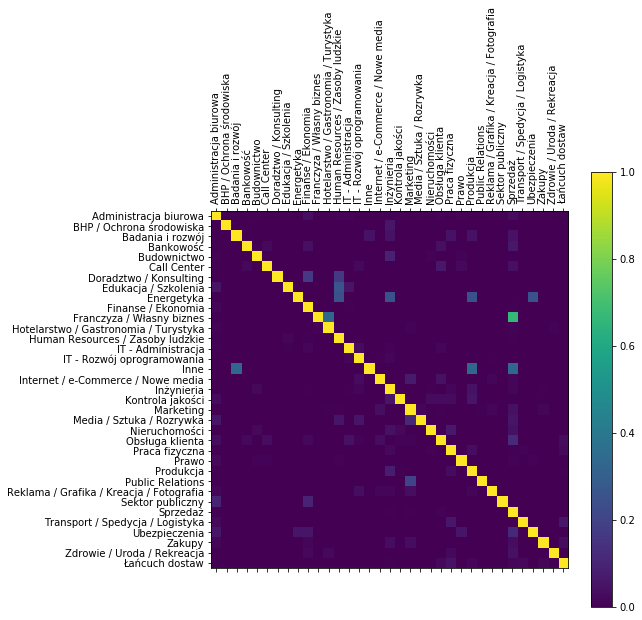

In [10]:
reduced_class_names = data.unique_class_names[2:]
true_matrix = create_matrix_from_labels([[x] for x in predictions.true_labels.values], reduced_class_names)
pred_matrix = create_matrix_from_labels(predictions.predicted_labels, reduced_class_names)
cooc_matrix = cooccurrence_matrix((true_matrix+pred_matrix))
plot_matrix(cooc_matrix, reduced_class_names)

Nasz model jest przydatny nie tylko do skutecznego przewidywania kategorii, ale może być również wykorzystany w wyszukiwaniu podobnych ofert pracy. <br> 
W ramach tego ćwiczenia utniemy sieć przed dekoderem i dla każdego wpisu otrzymamy jego reprezentację w przestrzeni wektorowej (po przejściu przez warstwę Embedding i Bidirectional(LSTM)). Następnie wybierzemy kilka ofert, dla których znajdziemy inne, najbardziej do nich podobne oferty. 

***Zadanie 4*** 
Wydziel z modelu reprezentację wektorową dokumentów. Aby to zrobić: 
- zidentyfikuj co jest inputem i outputem naszej "zredukowanej sieci" (zapisz nazwy warstw)
- stwórz kolejny, zredukowany model
- wygeneruj na nim predykcje
- sprawdź kształt wyniku. Coś nie pasuje, prawda?
- pozbądź się środkowego wymiaru poprzez uśrednienie. Każdy dokument powinien być reprezentowany poprzez jedną liczbę dla jednego timestepu (zauważ, że prawdopodobnie ostatni wymiar to nasze latent_dim*2 (mamy do czynienia z Bidirectional LSTM)
- ponownie sprawdź kształt wyniku
- **4a** Wygeneruj i przedstaw za pomocą wykresu reprezentację 2D naszych dokumentów.
- **4b** Porównaj ze sobą graficznie miejsca reprezentacji dwóch podobnych kategorii (np. IT - Rozwój oprogramowania i IT Administracja, albo Sprzedaż i Obsługa klienta)
- **4c** Porównaj ze sobą graficznie miejsca reprezentacji dwóch różnych kategorii (np. Marketing i Inżynieria)


In [11]:
model_names = [x.name for x in model.layers]
input_reduced = model.layers[0].input
output_reduced = model.layers[model_names.index("encoder")].output
model_reduced = Model(inputs=input_reduced, outputs=output_reduced)
vector_representations = model_reduced.predict(data.test_X)
#normalize 
vector_representations_avgd = np.zeros((vector_representations.shape[0], vector_representations.shape[2]))
for x in range(vector_representations.shape[0]):
    vector_representations_avgd[x] = np.mean(vector_representations[x], axis=0)
vector_representations = vector_representations_avgd

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.017s...
[t-SNE] Computed neighbors for 1500 samples in 1.731s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.443261
[t-SNE] Computed conditional probabilities in 0.081s
[t-SNE] Iteration 50: error = 67.3596191, gradient norm = 0.0861109 (50 iterations in 2.839s)
[t-SNE] Iteration 100: error = 64.9750595, gradient norm = 0.0676743 (50 iterations in 2.501s)
[t-SNE] Iteration 150: error = 64.5463943, gradient norm = 0.0572449 (50 iterations in 2.310s)
[t-SNE] Iteration 200: error = 64.5364380, gradient norm = 0.0569337 (50 iterations in 2.397s)
[t-SNE] Iteration 250: error = 64.5233307, gradient norm = 0.0427545 (50 iterations in 2.363s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.523331
[t-SNE] Iteration 300: error = 0.9885015, gradient norm = 0.0005831 (50 iterations in 2.331s

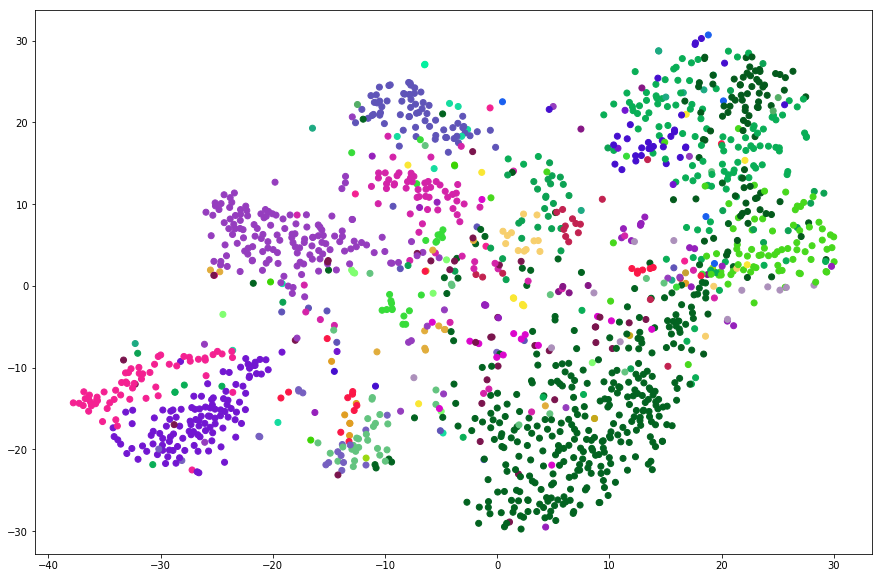

In [12]:
#4a
from sklearn.manifold import TSNE

tsne= TSNE(n_components=2, random_state=42, verbose=2, perplexity=50)
reduced_vector_representations = tsne.fit_transform(vector_representations)

colors_categories = {x: tuple(np.random.rand(3,1).reshape(-1)) for x in data.unique_class_names}
main_category = [tuple(colors_categories[x]) for x in data.raw_test_y]

plt.figure(figsize=(15,10))
plt.scatter(reduced_vector_representations[:,0], reduced_vector_representations[:,1], color=main_category)

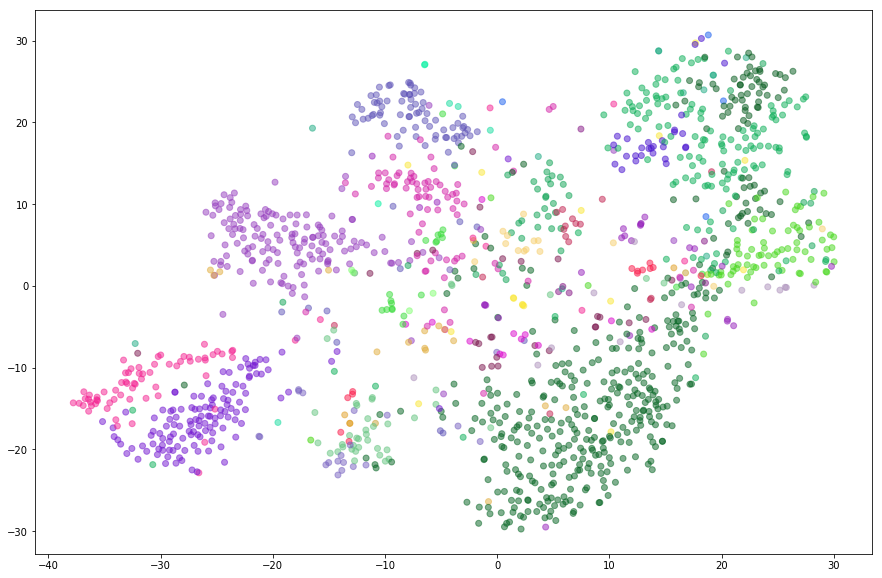

In [13]:
#4a - zrób to samo, tylko że dla przewidzianej kategorii (nie prawdziwej)
main_predicted_category = [tuple(colors_categories[x[0]]) for x in predictions.predicted_labels]
plt.figure(figsize=(15,10))
plt.scatter(reduced_vector_representations[:,0], reduced_vector_representations[:,1], color=main_predicted_category, alpha=0.5) 

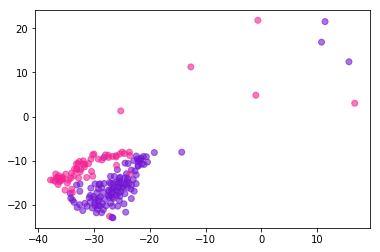

In [14]:
#4b i 4c
cat_a = 'IT - Rozwój oprogramowania'
cat_b = 'IT - Administracja'

similar_categories_ind = np.array([i for i,x in enumerate(data.raw_test_y) if x==cat_a or x==cat_b])
plt.scatter(reduced_vector_representations[similar_categories_ind,0], reduced_vector_representations[similar_categories_ind, 1], color=np.array(main_category)[similar_categories_ind], alpha=0.6)


**4.4** Oprócz reprezentacji wizualnej, wyszukamy najbardziej podobne treści ofert pracy za pomocą KNN (k-nearest neighbors). Napisz funkcję, która będzie wyświetlać n najbliższych sąsiadów danego wpisu. 

In [15]:
from sklearn.neighbors import NearestNeighbors

#fitujemy dla najbliższych 5 sąsiadów
nnb = NearestNeighbors(n_neighbors=5)
nnb.fit(vector_representations)

def get_nearest_position_names(indices, data):
    distances, indices = nnb.kneighbors(indices)
    names = []
    for i,x in enumerate(indices[0]):
        curr_entry = [np.array(data)[x], np.round(distances[0][i],3)]
        if curr_entry not in names:
            names.append(curr_entry)
    
    return names


example_ids = [14, 30, 47, 90, 32]
#wyszukaj 2 najbliższych sąsiadów dla 5 indeksów
for idx in example_ids:
    index_position_name = [vector_representations[i] for i,x in enumerate(data.raw_test_X) if i==idx][0]
    print(get_nearest_position_names(np.array(index_position_name).reshape(1,-1), data.raw_test_X))
    print("*"*10)

[[' . sygnity to wiodący polski dostawca rozwiązań informatycznych. na rynku działamy już od roku. oferujemy pełen zakres usług informatycznych i kompleksową obsługę w ośmiu kluczowych sektorach gospodarki. nasze rozwiązania stosuje większość banków w polsce wszystkie najważniejsze urzędy państwowe oraz największe koncerny energetyczne. posiadamy biura w miastach w polsce. kto tworzy sygnity eksperci dziedzinowi pasjonaci technologii mistrzowie transformacji i ambitni liderzy chcesz stać się częścią czołowej firmy w branży it szukamy ludzi z pasją którzy nie boją się nowych wyzwań i chcą stać się częścią firmy kochającej branżę it. rozpocznij zawodową karierę od projektów dla naprawdę wielkich graczy. aplikuj do sygnity u nas będziesz prowadzić analizę systemową projektować i rozbudowywać funkcjonalności związane z obiegiem dokumentów tworzyć szczegółową specyfikację wymagań projektować i implementować nowe funkcjonalności w zakresie obiegu dokumentów modelować procesy biznesowe dla kl

## W końcu atencja...
Kolejne dwa zadania będą wykorzystywać wyniki uzyskane dzięki mechanizmowi atencji. Jako że w tym zadaniu operujemy na przewidywanej sekwencji składającej się z jednego elementu, a także treści ofert pracy charakteryzują się znaczną długością, wizualizacja atencji tak jak jest dostępna w typowych publikacjach z tego zakresu (NMT) jest ciężka do osiągnięcia. Mimo tego, możemy sprawdzić, które słowa zostały zidentyfikowane jako najważniejsze dla każdej oferty pracy. 
<br>
<br>
Najpierw wczytamy predykcje z wagami atencji. 

In [16]:
network_probabilities = Network(args)
network_probabilities.return_probabilities = True
model_proba = load('./data/model_seq2seq_job_content.h5', network_probabilities)
probabilities = model_proba.predict([data.test_X, data.test_y_input])

model created


Poeksploruj kształt outputu z probabilities. Co Ci mówi? <br>
***Zadanie 5*** Napisz funkcję, która dla dowolnej predykcji  będzie zwracała top_n najważniejszych słów wraz z wartością ich wag. 
- input: indeks oferty pracy
- najpierw znajdź dla niej predykcję
- posortuj po najważniejszych argumentach
- dla każdego z najważniejszych argumentów odnajdź jakie to słowo i jaka jest jego waga


In [17]:
def display_most_significant_words(index, data, probabilities, predictions, top_n=10, least_significant = False):
    current_prediction = predictions[index]
    print("Real labels: {}".format(data.raw_test_y.values[index]))
    important_words = []
    for i in range(len(current_prediction)):
        print("Predicted: {}".format(current_prediction[i]))
        current_probabilities = np.squeeze(probabilities[index][:len(current_prediction)][i],axis=-1)
        highest_probabilities_args = list(reversed(list(np.argsort(current_probabilities))))[:top_n]
        if least_significant:
            highest_probabilities_args = list(np.argsort(current_probabilities))[:top_n]
            print("Least significant words: ")
        else:
            print("Most significant words: ")
        for arg in highest_probabilities_args:
            curr_word = data.tokenizer.sequences_to_texts([[data.test_X[index][arg]]])
            curr_proba = current_probabilities[arg]
            if curr_word[0] not in [x[0] for x in important_words]:
                important_words.append((curr_word[0], curr_proba))
        print(important_words)
        print("*"*10)


In [18]:
display_most_significant_words(300, data, probabilities, predictions.predicted_labels)

Real labels: Sprzedaż
Predicted: Sprzedaż
Most significant words: 
[('sprzedażowy', 0.3980049), ('handlowy', 0.1878798), ('detaliczny', 0.13758059), ('klient', 0.07285575), ('sprzedaż', 0.053014934), ('produkt', 0.012165216)]
**********


Real labels: ['Badania_i_rozwój']


/Users/agatawlaszczyk/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 432x288 with 0 Axes>

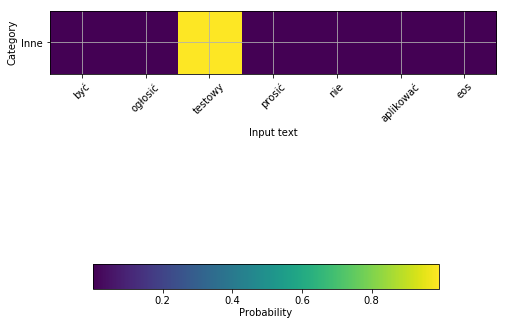

In [19]:
from keras.preprocessing.text import text_to_word_sequence

#dodatkowy kod do graficznej wizualizacji atencji

def sequence2txt(data, ind, tokenizer):
    return text_to_word_sequence(tokenizer.sequences_to_texts([data[ind]])[0])

def visualize_attention(index, network, data, probabilities, predictions, predicted=True):
    print("Real labels: {}".format(data.test_y.values[index][1:-1]))
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)
    # add image
    if predicted:
        output = predictions
    else:
        output = data.test_y.values
    i = ax.imshow(np.squeeze(probabilities[index][:len(output[index]),:len(sequence2txt(data.test_X, index, data.tokenizer))], axis=-1), interpolation='nearest')
    # add colorbar
    cbaxes = f.add_axes([0.2, 0.1, 0.6, 0.04])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Probability', labelpad=2)

    # add labels
    ax.set_yticks(range(network.num_decoder_tokens)[:len(output[index])])
    ax.set_yticklabels(output[index])
    ax.set_xticks(range(network.latent_dim)[:len(sequence2txt(data.test_X, index, data.tokenizer))])
    ax.set_xticklabels(sequence2txt(data.test_X, index, data.tokenizer), rotation=45)
    ax.set_xlabel('Input text')
    ax.set_ylabel('Category')
    ax.grid()

    f.show()
    
visualize_attention(np.argmin([len(x.split(" ")) for x in data.raw_test_X.values]), network, data, probabilities, predictions.predicted_labels)


In [20]:
# data.test_X[np.argmin([len(x.split(" ")) for x in data.raw_test_X.values])]
sequence2txt(data.test_X, 99, data.tokenizer)[:10]

['być', 'ogłosić', 'testowy', 'prosić', 'nie', 'aplikować', 'eos']

***Zadanie 6*** Napisz funkcję, która zbierze najważniejsze słowa dla wpisów należących do danej kategorii (przewidzianych). Funkcja powinna zwracać słownik, w której kluczami są słowa, a wartościami jest lista wartości odpowiadających wagom.
- znajdź odpowiednie id ofert z danej kategorii
- dla każdej z tych ofert zbierz najważniejsze dla niej słowa i ich wagi 
- zapisz każdy wynik w słowniku, w którym klucze to słowa, a wartości to lista wag atencji dla poszczególnych słów

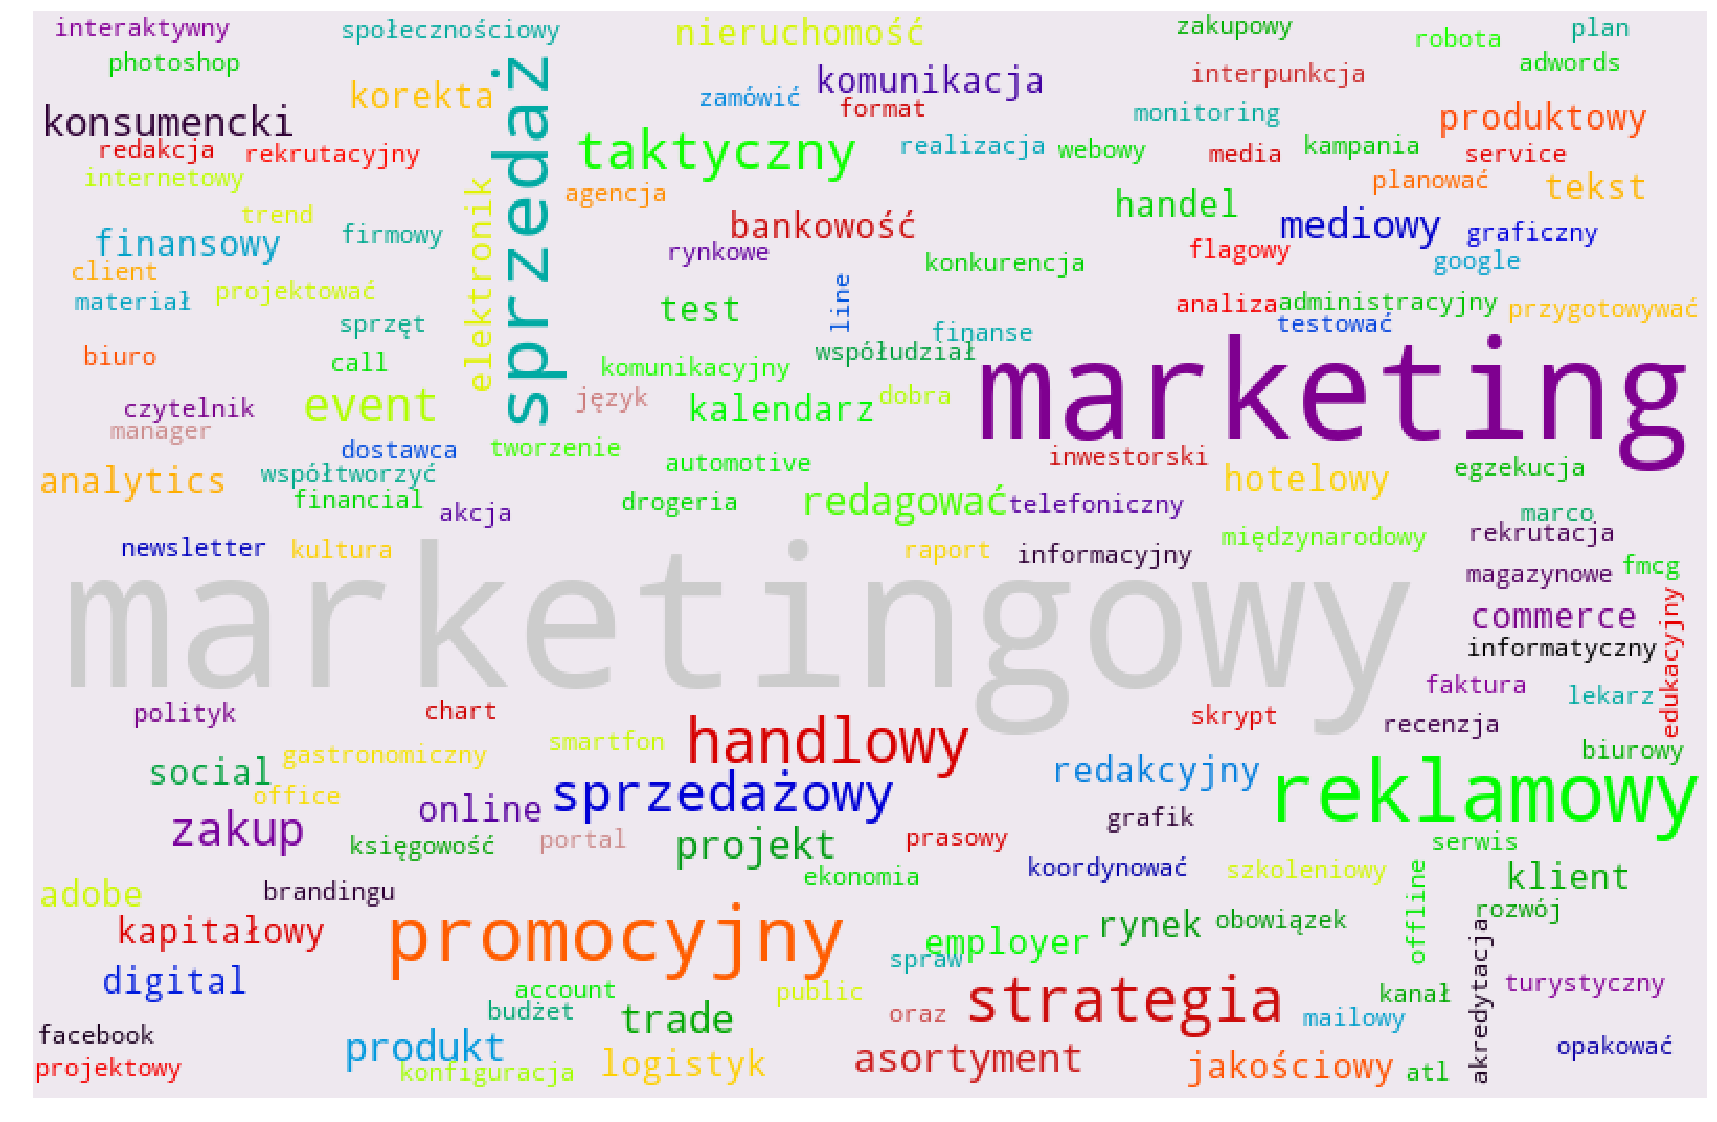

In [21]:
from wordcloud import WordCloud
def get_most_significant_word_category(category, data, probabilities, predictions, top_n=10):
    relevant_offers_ids = [i for i in range(len(data.test_X)) if category in predictions[i]]
    category_ids = [predictions[relevant_offers_ids[i]].index(category) for i,x in enumerate(relevant_offers_ids)]
    relevant_probabilities = probabilities[relevant_offers_ids, category_ids]
    relevant_probabilities = np.squeeze(relevant_probabilities, axis=-1)
    relevant_probabilities_args_sorted= np.argsort(-relevant_probabilities)[:,:top_n]
    words = {}
    
    for i,offer in enumerate(data.test_X[relevant_offers_ids]):
        curr_words = offer[relevant_probabilities_args_sorted[i]]
        for j,x in enumerate(curr_words):
            if x>0:
                words[data.tokenizer.index_word[x]] = words.get(data.tokenizer.index_word[x], [])
                words[data.tokenizer.index_word[x]].append(relevant_probabilities[i, relevant_probabilities_args_sorted[i,j]])
    return words   


def prepare_for_wordcloud_format(*args):
    summed_words_importance_dict = {}
    for dictionary in args:
        for key in dictionary.keys():
            summed_words_importance_dict[key] = summed_words_importance_dict.get(key, 0)
            summed_words_importance_dict[key] += int(np.ceil(10*sum(dictionary[key])))
    wordcloud_format_list = [(x[0] + " ")*x[1] for x in sorted(summed_words_importance_dict.items(), key=lambda x: x[1], reverse=True)]
    wordcloud_format_string = "".join(wordcloud_format_list)
    return wordcloud_format_string

def generate_wordcloud(wordcloud_string):
    wc = WordCloud(collocations=False, width=800, height=500, background_color='#eee8ef', colormap='nipy_spectral').generate(wordcloud_string)
    fig = plt.figure(figsize=(30,20))
    img = plt.imshow(wc, aspect='auto')
    plt.axis('off')
    plt.show()
    return 


generate_wordcloud(prepare_for_wordcloud_format(get_most_significant_word_category("Marketing", data, probabilities, predictions.predicted_labels)))



